In [21]:
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px





# Lade das Datenset
charging_set = pd.read_csv("data/cleaned_charging_set.csv")
charging_set.head(3)



,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,requestedDeparture_year,requestedDeparture_month,requestedDeparture_day,requestedDeparture_time,requestedDeparture_weekday,connectionDuration,chargingDuration,connect_weekday,disconnect_weekday,chargingDone_disconnect_difference
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,...,2020.0,1.0,2.0,20:51:54,3.0,6.039167,4.378056,3,3,1.661111
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,...,2020.0,1.0,2.0,23:31:50,3.0,9.025278,6.687500,3,3,2.337778
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,...,2020.0,1.0,2.0,14:56:35,3.0,10.713056,2.641944,3,4,8.071111


In [22]:
print(charging_set.columns)
# Anzahl der Lade-Events pro Tag berechnen
charging_set['connectionTime_time'] = pd.to_datetime(charging_set['connectionTime_time'])
charging_set['hour'] = charging_set['connectionTime_time'].dt.hour


events_at_day = charging_set.groupby('hour').size().reset_index(name='count')

# Count all loading-events over the available timeframe, ploted on hours of the day
fig = px.bar(
    events_at_day,
    x='hour',
    y='count',
    title='Loading-events over the day (siteID = all)',
    labels={'hour': 'Hour', 'count': 'Number of loading-events'}
)

# Layout adjustment
fig.update_traces(marker_color='#00008B')  # Color
fig.update_layout(
    title_font_size=18,
    legend_title_text="Legend",
    template="plotly_white"
)

# Show grafic
fig.show()


for site_id in [1, 2]:
    site_data = charging_set[charging_set['siteID'] == site_id]
    site_events_at_day = site_data.groupby('hour').size().reset_index(name='count')

    # Interactive visualization
    fig = px.bar(
        site_events_at_day,
        x='hour',
        y='count',
        title=f'Loading-events over the day (siteID = {site_id})',
        labels={'hour': 'Hour', 'count': 'Number of loading-events'},
    )

    fig.update_traces(marker_color='#1f77b4')

# Layout adjustment
    fig.update_layout(
        title_font_size=18,
        legend_title_text="Legend",
        template="plotly_white"
    )

    # Show grafic
    fig.show()

Index(['id', 'connectionTime', 'disconnectTime', 'doneChargingTime',
       'kWhDelivered', 'sessionID', 'siteID', 'spaceID', 'stationID', 'userID',
       'WhPerMile', 'kWhRequested', 'milesRequested', 'minutesAvailable',
       'modifiedAt', 'paymentRequired', 'requestedDeparture', 'isRegistered',
       'connectionTime_year', 'connectionTime_month', 'connectionTime_day',
       'connectionTime_time', 'connectionTime_weekday', 'disconnectTime_year',
       'disconnectTime_month', 'disconnectTime_day', 'disconnectTime_time',
       'disconnectTime_weekday', 'doneChargingTime_year',
       'doneChargingTime_month', 'doneChargingTime_day',
       'doneChargingTime_time', 'doneChargingTime_weekday', 'modifiedAt_year',
       'modifiedAt_month', 'modifiedAt_day', 'modifiedAt_time',
       'modifiedAt_weekday', 'requestedDeparture_year',
       'requestedDeparture_month', 'requestedDeparture_day',
       'requestedDeparture_time', 'requestedDeparture_weekday',
       'connectionDuration', 

In [23]:
# Aggregation on months
month_names = {
    1: "January", 2: "February", 3: "March", 4: "April", 
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

events_per_month = charging_set.groupby('connectionTime_month').size().reset_index(name='count')

# Add month names
events_per_month['month_name'] = events_per_month['connectionTime_month'].map(month_names)

# Count all loading-events over the available timeframe, ploted on hours of the day
fig = px.bar(
    events_per_month,
    x='month_name',
    y='count',
    title='Loading-events per month (sideID = all)',
    labels={'hour': 'Month', 'count': 'Number of loading-events'}
)

# Layout adjustment
fig.update_traces(marker_color='#FF8C00')  # Color
fig.update_layout(
    title_font_size=18,
    legend_title_text="Legend",
    template="plotly_white"
)

# Show grafic
fig.show()



In [24]:
events_per_year = charging_set.groupby('connectionTime_year').size().reset_index(name='count')


# Count all loading-events over the available timeframe, ploted per year
fig = px.bar(
    events_per_year,
    x='connectionTime_year',
    y='count',
    title='Loading-events per year (siteID = all)',
    labels={'hour': 'connectionTime_year', 'count': 'Number of loading-events'}
)

# Layout adjustment
fig.update_traces(marker_color='#00008B')  # Color
fig.update_layout(
    title_font_size=18,
    legend_title_text="Legend",
    template="plotly_white",
     xaxis=dict(
        tickmode='array',  # Specify ticks explicitly
        tickvals=events_per_year['connectionTime_year'].unique(),  # Use unique years as tick values
        title="Year"
    )
)

# Show grafic
fig.show()




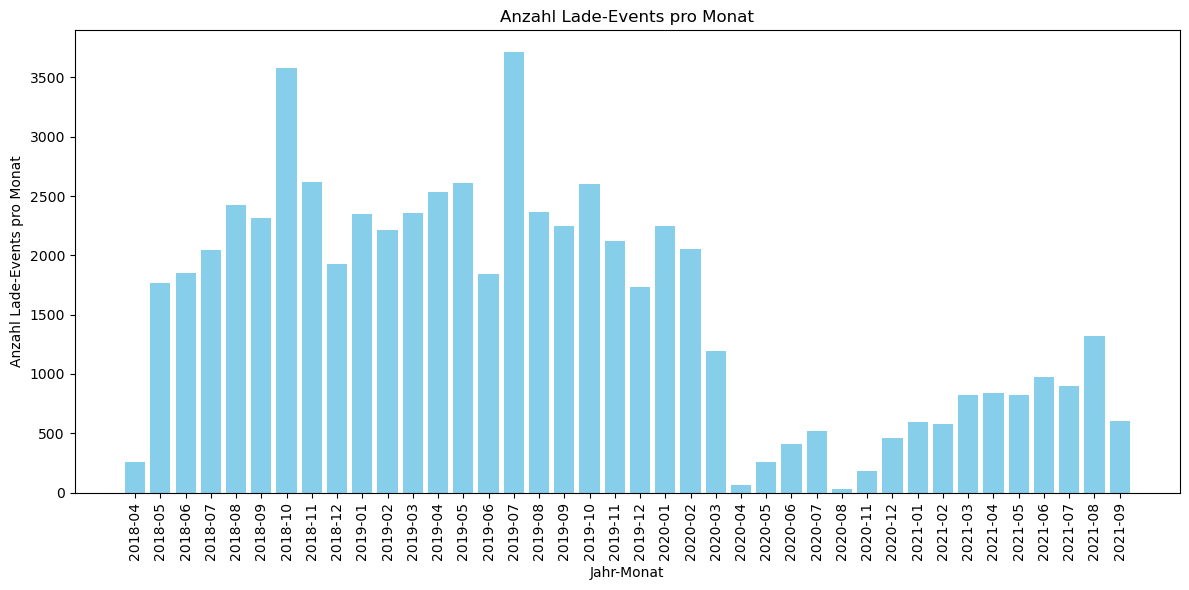

In [27]:
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])

# Jahr und Monat extrahieren
charging_set['year'] = charging_set['connectionTime_year']
charging_set['month'] = charging_set['connectionTime_month']

# Berechnung der durchschnittlichen Temperatur pro Jahr und Monat
avg_temperatures = charging_set.groupby(['year', 'month']).size().reset_index(name='count')

# Erstellen des Balkendiagramms
plt.figure(figsize=(12, 6))
# Kombiniere Jahr und Monat für die X-Achse, z.B. '2022-01' für Januar 2022
avg_temperatures['year_month'] = avg_temperatures['year'].astype(str) + '-' + avg_temperatures['month'].astype(str).str.zfill(2)

# Erstellen des Balkendiagramms
plt.bar(avg_temperatures['year_month'], avg_temperatures['count'], color='skyblue')

# Titel und Beschriftungen
plt.title('Anzahl Lade-Events pro Monat')
plt.xlabel('Jahr-Monat')
plt.ylabel('Anzahl Lade-Events pro Monat')

# Optional: X-Achse formatieren (dreh die Labels, damit sie lesbar sind)
plt.xticks(rotation=90)

# Layout optimieren
plt.tight_layout()

# Diagramm anzeigen
plt.show()

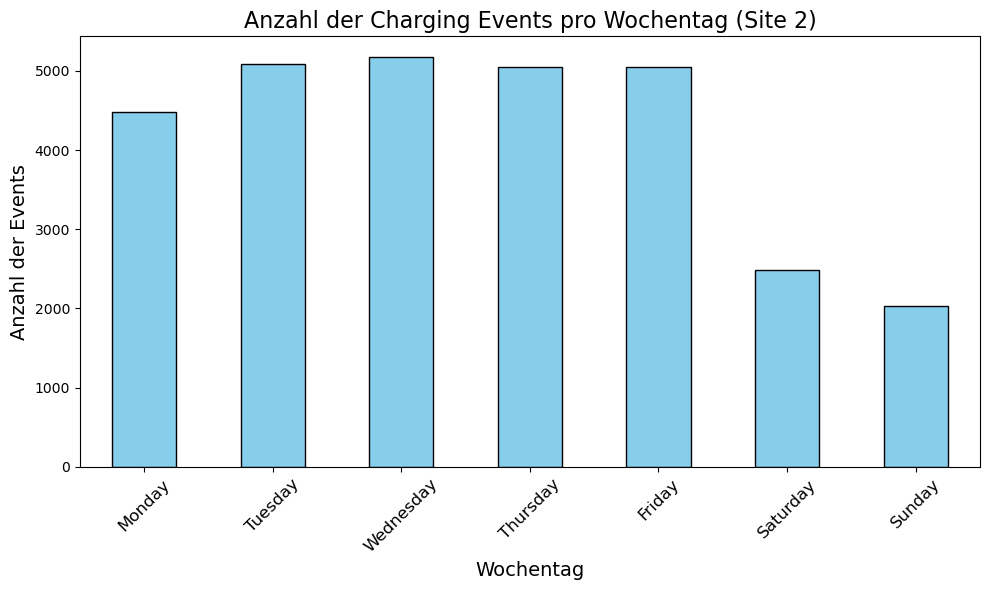

In [38]:
site_data = charging_set[charging_set['siteID'] == 2]

# Konvertiere die Spalte `connectionTime_date` in ein Datetime-Format
site_data['connection_date'] = pd.to_datetime(site_data['connectionTime'])

# Extrahiere den Wochentag
site_data['weekday'] = site_data['connection_date'].dt.day_name()

# Zähle die Anzahl der Charging Events pro Wochentag
weekday_counts = site_data['weekday'].value_counts()

# Sortiere die Wochentage in der korrekten Reihenfolge
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(weekday_order)

# Balkendiagramm erstellen
plt.figure(figsize=(10, 6))
weekday_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Anzahl der Charging Events pro Wochentag (Site 2)', fontsize=16)
plt.xlabel('Wochentag', fontsize=14)
plt.ylabel('Anzahl der Events', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Diagramm anzeigen
plt.show()


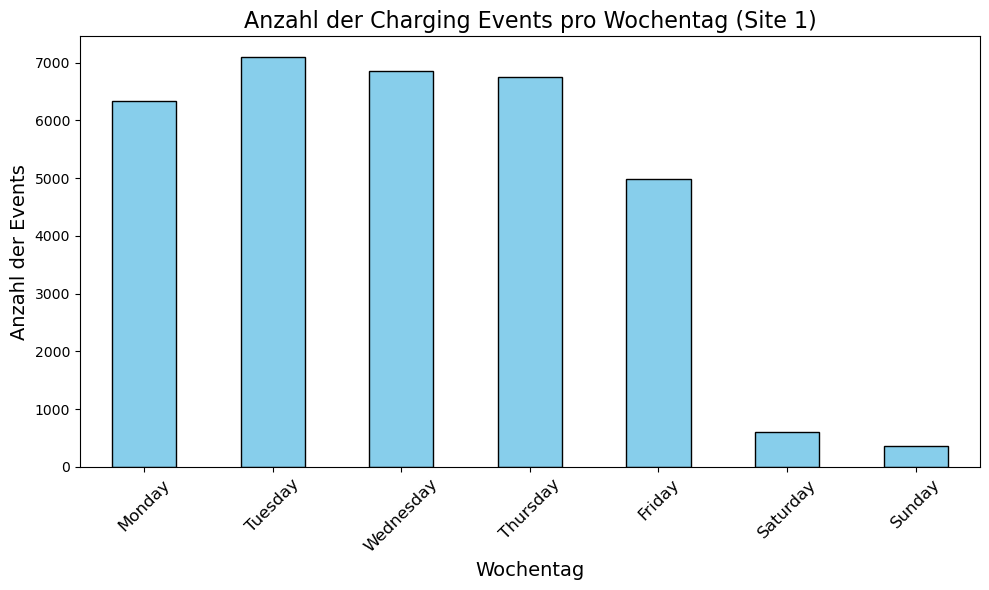

In [40]:
site_data = charging_set[charging_set['siteID'] == 1]

# Konvertiere die Spalte `connectionTime_date` in ein Datetime-Format
site_data['connection_date'] = pd.to_datetime(site_data['connectionTime'])

# Extrahiere den Wochentag
site_data['weekday'] = site_data['connection_date'].dt.day_name()

# Zähle die Anzahl der Charging Events pro Wochentag
weekday_counts = site_data['weekday'].value_counts()

# Sortiere die Wochentage in der korrekten Reihenfolge
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(weekday_order)

# Balkendiagramm erstellen
plt.figure(figsize=(10, 6))
weekday_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Anzahl der Charging Events pro Wochentag (Site 1)', fontsize=16)
plt.xlabel('Wochentag', fontsize=14)
plt.ylabel('Anzahl der Events', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Diagramm anzeigen
plt.show()


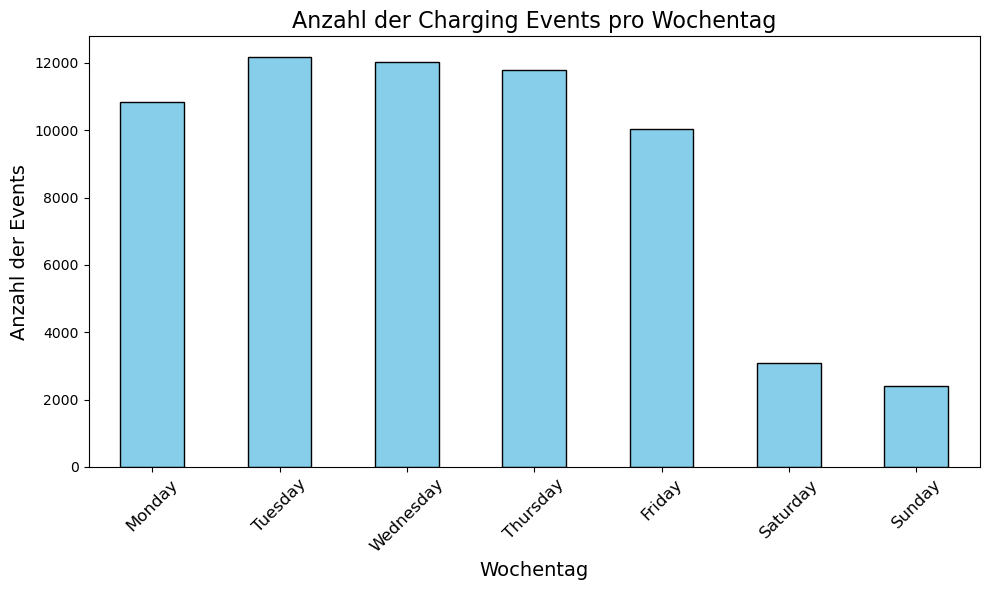

In [41]:
# Konvertiere die Spalte `connectionTime_date` in ein Datetime-Format
charging_set['connection_date'] = pd.to_datetime(charging_set['connectionTime'])

# Extrahiere den Wochentag
charging_set['weekday'] = charging_set['connection_date'].dt.day_name()

# Zähle die Anzahl der Charging Events pro Wochentag
weekday_counts = charging_set['weekday'].value_counts()

# Sortiere die Wochentage in der korrekten Reihenfolge
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(weekday_order)

# Balkendiagramm erstellen
plt.figure(figsize=(10, 6))
weekday_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Anzahl der Charging Events pro Wochentag', fontsize=16)
plt.xlabel('Wochentag', fontsize=14)
plt.ylabel('Anzahl der Events', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()

# Diagramm anzeigen
plt.show()


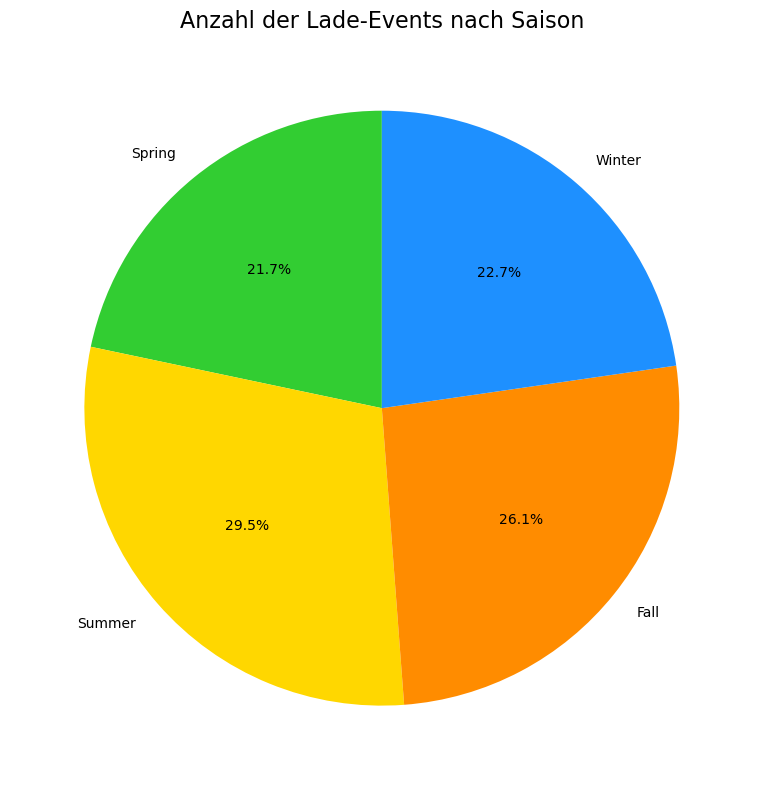

In [46]:
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])

# Aggregation auf Monatsbasis
events_per_month = charging_set.groupby(charging_set['connectionTime'].dt.month).size().reset_index(name='count')
events_per_month.rename(columns={'connectionTime': 'month'}, inplace=True)

# Mapping von Monaten zu Saisons
def map_month_to_season(month):
    if month in [12, 1, 2]:  # Winter
        return 'Winter'
    elif month in [3, 4, 5]:  # Spring
        return 'Spring'
    elif month in [6, 7, 8]:  # Summer
        return 'Summer'
    elif month in [9, 10, 11]:  # Fall
        return 'Fall'

# Hinzufügen einer "season"-Spalte
events_per_month['season'] = events_per_month['month'].apply(map_month_to_season)

# Aggregation der Events auf Basis der Saison
events_per_season = events_per_month.groupby('season')['count'].sum().reindex(['Spring', 'Summer', 'Fall', 'Winter'])

# Pie Chart erstellen
plt.figure(figsize=(8, 8))
events_per_season.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#32CD32', '#FFD700', '#FF8C00', '#1E90FF'])
plt.title('Anzahl der Lade-Events nach Saison', fontsize=16)
plt.ylabel('')  # Entfernt die Standard-Y-Achsentitel
plt.tight_layout()

# Diagramm anzeigen
plt.show()


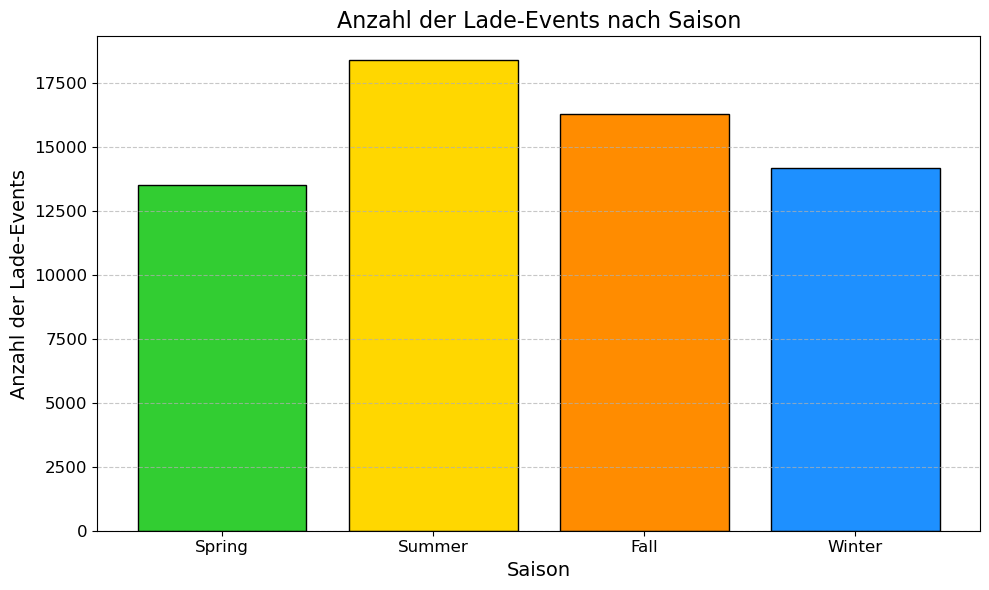

In [47]:
charging_set['connectionTime'] = pd.to_datetime(charging_set['connectionTime'])

# Aggregation auf Monatsbasis
events_per_month = charging_set.groupby(charging_set['connectionTime'].dt.month).size().reset_index(name='count')
events_per_month.rename(columns={'connectionTime': 'month'}, inplace=True)

# Mapping von Monaten zu Saisons
def map_month_to_season(month):
    if month in [12, 1, 2]:  # Winter
        return 'Winter'
    elif month in [3, 4, 5]:  # Spring
        return 'Spring'
    elif month in [6, 7, 8]:  # Summer
        return 'Summer'
    elif month in [9, 10, 11]:  # Fall
        return 'Fall'

# Hinzufügen einer "season"-Spalte
events_per_month['season'] = events_per_month['month'].apply(map_month_to_season)

# Aggregation der Events auf Basis der Saison
events_per_season = events_per_month.groupby('season')['count'].sum().reindex(['Spring', 'Summer', 'Fall', 'Winter'])

# Visualisierung als Balkendiagramm
plt.figure(figsize=(10, 6))
plt.bar(events_per_season.index, events_per_season.values, color=['#32CD32', '#FFD700', '#FF8C00', '#1E90FF'], edgecolor='black')
plt.title('Anzahl der Lade-Events nach Saison', fontsize=16)
plt.xlabel('Saison', fontsize=14)
plt.ylabel('Anzahl der Lade-Events', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Diagramm anzeigen
plt.show()


### KPIs:

- General Utilization (relative)
- ...

In [48]:
# Convert connection and charging durations to hours
charging_set['connectionDuration_hours'] = charging_set['connectionDuration'] / 3600  # Convert to hours
charging_set['chargingDuration_hours'] = charging_set['chargingDuration'] / 3600  # Convert to hours

# Calculate total connection and charging durations per year
utilization_per_year = charging_set.groupby('connectionTime_year').agg(
    TotalConnectionTime=('connectionDuration_hours', 'sum'),
    TotalChargingTime=('chargingDuration_hours', 'sum')
).reset_index()

# Calculate total available time
total_sites = charging_set['siteID'].nunique()  # Number of unique sites
hours_per_year = 8760  # Total hours in a year (non-leap year)
utilization_per_year['TotalAvailableTime'] = total_sites * hours_per_year  # Total time available per year

# Calculate utilization rates
utilization_per_year['ConnectionUtilizationRate'] = (utilization_per_year['TotalConnectionTime'] / utilization_per_year['TotalAvailableTime']) * 100
utilization_per_year['ChargingUtilizationRate'] = (utilization_per_year['TotalChargingTime'] / utilization_per_year['TotalAvailableTime']) * 100

# Visualization: Connection utilization (gross)
fig1 = px.bar(
    utilization_per_year,
    x='connectionTime_year',
    y='ConnectionUtilizationRate',
    title='Brutto-Auslastung (Verbindungszeit) der Ladestationen pro Jahr',
    labels={'connectionTime_year': 'Jahr', 'ConnectionUtilizationRate': 'Auslastung (%)'}
)

fig1.update_traces(marker_color='#00008B')  # Dark blue for connection utilization
fig1.update_layout(
    title_font_size=18,
    legend_title_text="Legende",
    template="plotly_white",
    xaxis=dict(
        tickmode='array',  # Only display whole years
        tickvals=utilization_per_year['connectionTime_year'].unique(),
        title="Jahr"
    ),
    yaxis=dict(
        title="Auslastung (%)"
    )
)

# Visualization: Charging utilization (net)
fig2 = px.bar(
    utilization_per_year,
    x='connectionTime_year',
    y='ChargingUtilizationRate',
    title='Netto-Auslastung (Ladezeit) der Ladestationen pro Jahr',
    labels={'connectionTime_year': 'Jahr', 'ChargingUtilizationRate': 'Auslastung (%)'}
)

fig2.update_traces(marker_color='#FF8C00')  # Orange for charging utilization
fig2.update_layout(
    title_font_size=18,
    legend_title_text="Legende",
    template="plotly_white",
    xaxis=dict(
        tickmode='array',  # Only display whole years
        tickvals=utilization_per_year['connectionTime_year'].unique(),
        title="Jahr"
    ),
    yaxis=dict(
        title="Auslastung (%)"
    )
)

# Show the graphics
fig1.show()
fig2.show()